## Logistic Regression For Costa Rican Poverty Prediction

### Outline
**1. Project Setup** \
*1.1 Load Data and Packages* \
*1.2 Data Cleaning* \
*1.3 Oversampling* \
\
**2. What is a logistic regression?** \
*2.1 Summary of Approach* \
\
**3. Models** \
*3.1 Basic Models* \
*3.2 Improving Model Performance* \
\
**4. Findings, Limitations and Next Steps**

## 1. Project Setup

**1.1 Load Data**

In [162]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, classification_report
import load_data as ld
from collections import Counter
import numpy as np
from sklearn.feature_selection import RFE
df, X_valid, y_valid = ld.load_train_data()


/Users/katherinedumais/anaconda3/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


**1.2 Data Cleaning**

In [163]:
cols_to_drop = ['Id', 'idhogar', 'rez_esc']

for dfs in [df, X_valid, y_valid]:
    dfs.replace([np.inf, -np.inf], np.nan, inplace=True) # Written by Kathryn Link-Oberstar 
    for col in cols_to_drop:
        if col in dfs.columns:
            dfs.drop(col, axis=1, inplace=True)
    dfs.fillna(df.mean(), inplace=True)

In [164]:

def evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = False):
    '''
    Written by Kathryn Link- Oberstar 
    '''
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Recall:", recall)
    if cm is True:
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()

**1.3 Create oversampling:**\
We are looking to better predict Costa Rican Poverty in the following categories: 
- 1 = extreme poverty
- 2 = moderate poverty
- 3 = vulnerable households
- 4 = non vulnerable households

However, as demonstrated in our exploratory analysis, the majority of the data (66%) comes from class 4. Thus, a strong training model is most likely to predict the majority class rather than give accurate weights and biases as to reflect the different categories. 

As such we attempt to do over sampling- with random oversampling, SMOTE and ADASYM. We try random sampling with replacement as well as SVM SMOTE (Support Vector Machine Synthetic Minority Over-sampling Technique), which creates synthetic samples by randomly sampling the characteristics from occurrences in the minority class. The SVM class is designed for small and complex datasets. For SVM SMOTE, a neighborhood is defined using the parameter m_neighbors to decide if a sample is in danger, safe, or noise.

This gives us a number of different datasets to work with, so we can see how oversampling can impact our models.

In this case we are only looking at heads of household as a representative for their household. 


In [165]:
X = df.iloc[: , :-1]
y = df.loc[:, 'Target']
print("overall",sorted(Counter(y).items()))
1579/len(y)
from imblearn.over_sampling import RandomOverSampler, SVMSMOTE
ros = RandomOverSampler(random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
train_df_resampled, train_y_resampled = ros.fit_resample(X_train, y_train)
print("original y valid", sorted(Counter(y_train).items()))
print( "Random Sampling", sorted(Counter(train_y_resampled).items()))

sm = SVMSMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
print("SMOTE", sorted(Counter(train_y_resampled).items()))


overall [(1, 171), (2, 346), (3, 282), (4, 1579)]
original y valid [(1, 137), (2, 267), (3, 236), (4, 1262)]
Random Sampling [(1, 1262), (2, 1262), (3, 1262), (4, 1262)]
SMOTE [(1, 1262), (2, 1262), (3, 1262), (4, 1262)]


## 2. What is Logistic Regression? 

Logistic Regression is a type of supervised learning algorithm used for classification problems which uses a logistic function to model the probability of a binary or categorical outcome. In our case, our 1-4 levels of poverty produce categorical variables. 

The goal of logistic regression is to find the best parameters of a logistic function that minimizes the difference between the predicted probabilities and the actual outcomes. The logistic function uses the sigmoid function, which maps any real number into a range between 0 and 1, allowing us to interpret the output as a probability. The input features are weighted and combined linearly, and the resulting value is passed through the logistic function to produce a probability. We then use gradient descent to determine what the best classification is for these categories. 

One drawback however, is that it assumes linear relationships which based on the diversity of our data, may not be true in this case. 


### 2.1 What is Regularization
Regularization helps to improve the generalization performance of the model by balancing the bias-variance trade-off and reducing overfitting.  By penalizing the weights of the input features, regularization encourages the model to focus on the most important features that are most relevant to the target variable. Overfitting occurs when a model learns to fit the training data too closely, including noise and irrelevant features, leading to poor generalization performance on new, unseen data. In this case we will try L2 regularization which adds a penalty term proportional to the square of the weights.

## 3. Models
*3.1 Basic Models*


In [166]:
logreg = LogisticRegression(random_state=42)

# fit the model with data

reg = LogisticRegression(solver='lbfgs', penalty=None, max_iter=1000).fit(X_train, y_train)
y_pred = reg.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = False)

print("Random Sampling")
reg = LogisticRegression(solver='lbfgs', penalty=None, max_iter=1000).fit(train_df_resampled, train_y_resampled)
y_pred = reg.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = False)

print("SVM SMOTE")
reg = LogisticRegression(solver='lbfgs', penalty=None, max_iter=1000).fit(X_smote, y_smote)
y_pred = reg.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = False)



/Users/katherinedumais/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6764705882352942
F1 Score: 0.5759335256785341
Recall: 0.6764705882352942
Random Sampling


/Users/katherinedumais/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.47478991596638653
F1 Score: 0.5283562876566927
Recall: 0.4747899159663866
SVM SMOTE
Accuracy: 0.5714285714285714
F1 Score: 0.5972263574602699
Recall: 0.5714285714285714


/Users/katherinedumais/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


*2.1 With Regularization*

As demonstrated below, regularization is crucial to the success of these models. It also allows us to use a better solver for smaller datasets: liblinear. It also has a substantially higher F1 score. However, the randomly selected do a better job of classifying the data into the correct catergory. 

Accuracy: 0.6764705882352942
F1 Score: 0.5675998345008632
Recall: 0.6764705882352942
Random Sampling
Accuracy: 0.5525210084033614
F1 Score: 0.5933924138163184
Recall: 0.5525210084033614
SVM SMOTE
Accuracy: 0.6785714285714286
F1 Score: 0.6500106294125575
Recall: 0.6785714285714286


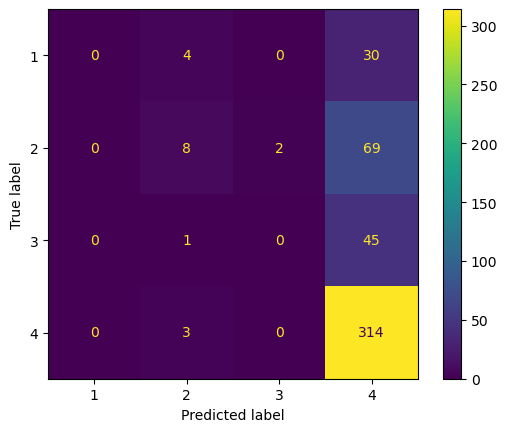

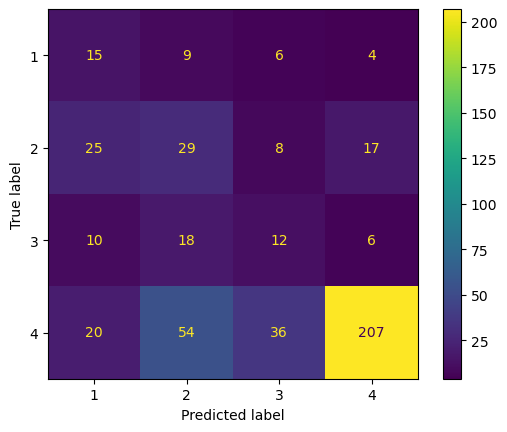

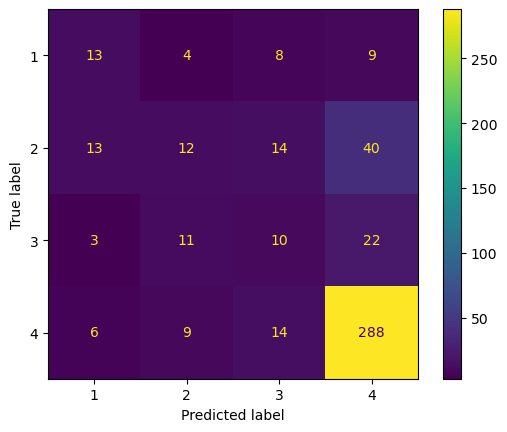

In [167]:
logreg = LogisticRegression(random_state=42)

# fit the model with data

reg = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred = reg.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = True)

print("Random Sampling")
reg = LogisticRegression(solver='liblinear', penalty='l2').fit(train_df_resampled, train_y_resampled)
y_pred = reg.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = True)

print("SVM SMOTE")
reg = LogisticRegression(solver='liblinear', penalty='l2').fit(X_smote, y_smote)
y_pred = reg.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = True)


*3.2 Improve Model Performance*

Adding Feature selection to these models as shown below does not seem to increase accuracy in a meaningful way - Particularly in characterization of 1's and two's. 

With Smote- RFE
Accuracy: 0.6785714285714286
F1 Score: 0.6500106294125575
Recall: 0.6785714285714286
With Random Selection- RFE
Accuracy: 0.6785714285714286
F1 Score: 0.6500106294125575
Recall: 0.6785714285714286
With Smote- Variance Threshold
Accuracy: 0.6638655462184874
F1 Score: 0.6483378884265315
Recall: 0.6638655462184874
With Random Selection- RFE
Accuracy: 0.5819327731092437
F1 Score: 0.6177735157978849
Recall: 0.5819327731092437


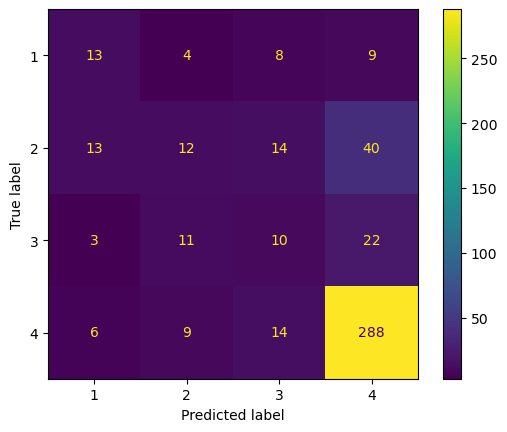

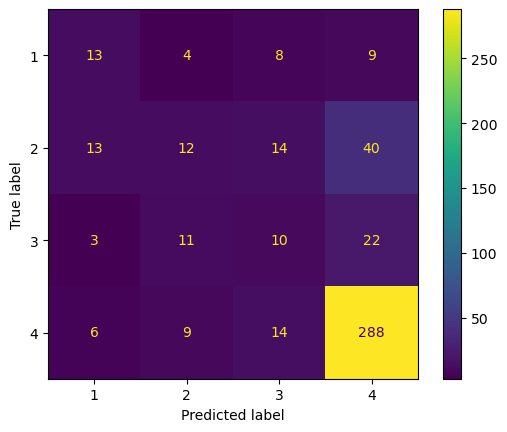

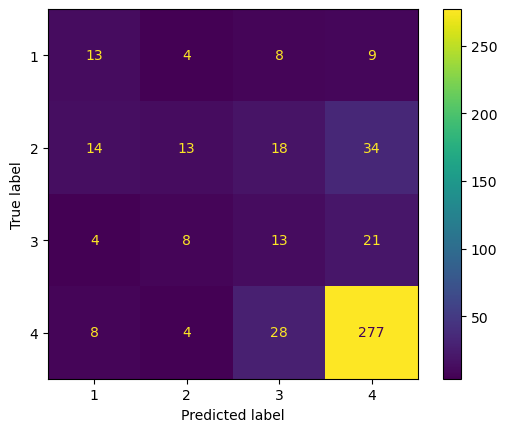

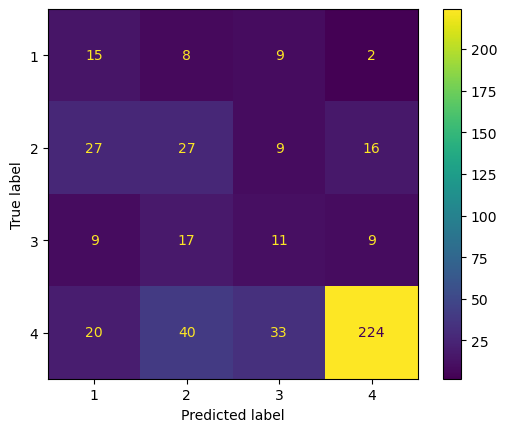

In [168]:
print("With Smote- RFE")
#Recursive feature elimination
rfe_selector = RFE(estimator=LogisticRegression(solver='liblinear', penalty='l2'),n_features_to_select = 10, step = 1)
rfe_selector.fit(X_smote, y_smote)
y_pred = reg.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = True)

print("With Random Selection- RFE")
#Recursive feature elimination
rfe_selector = RFE(estimator=LogisticRegression(solver='liblinear', penalty='l2'),n_features_to_select = 10, step = 1)
rfe_selector.fit(train_df_resampled, train_y_resampled)
y_pred = reg.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = True)

print("With Smote- Variance Threshold")
# get rid of features without a lot of variance 
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
rev_x = sel.fit_transform(X_smote.copy())
reg = LogisticRegression(solver='liblinear', penalty='l2').fit(rev_x, y_smote)

y_pred = reg.predict(sel.transform(X_valid.copy()))
evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = True)


print("With Random Selection- RFE")

# get rid of features without a lot of variance 
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
rev_x = sel.fit_transform(train_df_resampled.copy())
reg = LogisticRegression(solver='liblinear', penalty='l2').fit(rev_x, train_y_resampled)

y_pred = reg.predict(sel.transform(X_valid.copy()))
evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = True)


#from sklearn.feature_selection import SequentialFeatureSelector
#Selecting the Best important features according to Logistic Regression
#sfs_selector = SequentialFeatureSelector(estimator=LogisticRegression(solver='liblinear', penalty='l2'), n_features_to_select = 2, cv =10, direction ='backward')
#sfs_selector.fit(X_smote, y_smote)
#_pred = sfs_selector.predict(X_valid)
#evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = True)


**4. Findings, Limitations and Next Steps**

Our models regardless of oversampling are fairly accurate at predicting 4, but need more data to provide any meaningful accuracy using logistic regression to predict the lower categories at any meaningful amount of accuracy. 